# Multi-class classification using pytorch

## import library

In [430]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torchvision.transforms.functional as F2
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os

## load data

In [431]:
directory_data  = './sample_data'
filename_data   = 'assignment_06_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

x_train = data['x_train']
y_train = data['y_train']

x_test  = data['x_test']
y_test  = data['y_test']

num_data_train  = x_train.shape[0]
num_data_test   = x_test.shape[0]

In [432]:
print('*************************************************')
print('size of x_train :', x_train.shape)
print('size of y_train :', y_train.shape)
print('*************************************************')
print('size of x_test :', x_test.shape)
print('size of y_test :', y_test.shape)
print('*************************************************')
print('number of training image :', x_train.shape[0])
print('height of training image :', x_train.shape[1])
print('width of training image :', x_train.shape[2])
print('*************************************************')
print('number of testing image :', x_test.shape[0])
print('height of testing image :', x_test.shape[1])
print('width of testing image :', x_test.shape[2])
print('*************************************************')

*************************************************
size of x_train : (20000, 32, 32)
size of y_train : (20000,)
*************************************************
size of x_test : (8000, 32, 32)
size of y_test : (8000,)
*************************************************
number of training image : 20000
height of training image : 32
width of training image : 32
*************************************************
number of testing image : 8000
height of testing image : 32
width of testing image : 32
*************************************************


## number of classes

In [433]:
print('*************************************************')
print('number of classes :', len(set(y_train)))
print('*************************************************')

*************************************************
number of classes : 10
*************************************************


## custom data loader for the PyTorch framework

In [434]:
class dataset(Dataset):
    
    def __init__(self, image, label):
        
        self.image  = image
        self.label  = label.astype(int)
    
    def __getitem__(self, index):
        
        image   = self.image[index, :, :]
        label   = self.label[index, ]

        image   = torch.FloatTensor(image).unsqueeze(dim=0)
        label   = torch.LongTensor([label])

        return image, label
    
    def __len__(self):
        
        return self.image.shape[0]

    def collate_fn(self, batch):
        images  = list()
        labels  = list()

        for b in batch:
            images.append(b[0])
            labels.append(b[1])

        images  = torch.stack(images, dim=0)
        labels  = torch.stack(labels, dim=0).squeeze()

        return images, labels

## setting device (cpu or gpu)

In [435]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [436]:
print(device)
print(type(device))

cpu
<class 'torch.device'>


## construct datasets and dataloaders for training and testing

In [437]:
# ================================================== 
# determine the value of the following parameter
#
size_minibatch      = 200
#
# ================================================== 
print("x,y train type: ", type(x_train))
dataset_train       = dataset(x_train, y_train)
dataset_test        = dataset(x_test, y_test)
print("dataset() type: ", type(dataset_train))

dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True, collate_fn=dataset_train.collate_fn)
dataloader_test     = torch.utils.data.DataLoader(dataset_test, batch_size=size_minibatch, shuffle=True, drop_last=True, collate_fn=dataset_test.collate_fn)
print("dataloader_train type : ", type(dataloader_train))

x,y train type:  <class 'numpy.ndarray'>
dataset() type:  <class '__main__.dataset'>
dataloader_train type :  <class 'torch.utils.data.dataloader.DataLoader'>


## shape of the data when using the data loader

In [438]:
image, label    = next(iter(dataloader_train))

In [439]:
print('************************************************************')
print('size of mini-batch of the image:', image.shape)
print('************************************************************')
print('size of mini-batch of the label:', label.shape)
print('************************************************************')

************************************************************
size of mini-batch of the image: torch.Size([200, 1, 32, 32])
************************************************************
size of mini-batch of the label: torch.Size([200])
************************************************************


## construct a neural network 

In [440]:
# ================================================== 
# define the neural network architecture
#
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.feature    = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),

            nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, stride=1, padding=1, bias=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),

            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1, bias=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(32, 16, bias=True),
            nn.ReLU(),
            nn.Linear(16, 10, bias=True),
        )

        self.network    = nn.Sequential(
            self.feature,
            nn.Flatten(),
            self.classifier,
        )

        self.initialize()


    def initialize(self):

        for m in self.network.modules():

            if isinstance(m, nn.Conv2d):

                #nn.init.constant_(m.weight, 0.01)
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 1)

            elif isinstance(m, nn.Linear):
    
                #nn.init.constant_(m.weight, 0.01)
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 1)


    def forward(self, input):

        output = self.network(input)

        return output
#
# ================================================== 

In [441]:
# #### My Test ####
# csfr = Classifier()
# print(type(csfr))
# otp = csfr.forward(image)
# print(type(otp))
# print(otp.shape)
# # print(label.reshape(1, 100).shape)
# # d = F.one_hot(label, num_classes=10)
# cel = nn.CrossEntropyLoss()
# myTest_loss = cel(otp, label)
# print(myTest_loss)

# loss_value = myTest_loss.item()
# print(loss_value)
# print("loss_value type : ", type(loss_value))

# ### argmax ###
# # print(otp)
# argmax_otp = torch.argmax(otp, dim=1)
# print(argmax_otp)
# print(label)
# print( argmax_otp == label)
# print(sum(argmax_otp == label))
# print(label.shape)
# print("len = ", len(label))
# print(type(label.size(dim=0)))

## build network

In [442]:
# ================================================== 
# determine the value of the following parameter
#
learning_rate   = 0.05
weight_decay    = 0.001
#
# ================================================== 

classifier      = Classifier().to(device)
optimizer       = torch.optim.SGD(classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [443]:
print(classifier)

Classifier(
  (feature): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True

## compute the prediction

In [444]:
def compute_prediction(model, input):

# ================================================== 
# fill up the blank
# 
    prediction = model.forward(input)
    
#
# ================================================== 

    return prediction

## compute the loss
- use `CrossEntropyLoss`
- compute loss and its value (`loss.item()`)

In [445]:
def compute_loss(prediction, label):

# ================================================== 
# fill up the blank
#    
 
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(prediction, label)

#
# ================================================== 

    return loss

## compute the loss value

In [446]:
def compute_loss_value(loss):
    
    loss_value = loss.item()
    
    return loss_value

## compute the accuracy
- accuracy in percentile : 0 - 100 (%)

In [447]:
def compute_accuracy(prediction, label):

# ================================================== 
# fill up the blank
#         
    argmax_pred = torch.argmax(prediction, dim=1)
    
    accuracy = sum(argmax_pred == label) / label.size(dim=0)

#
# ================================================== 

    return accuracy

## variables for the learning curve

In [448]:
# ================================================== 
# determine the value of the following parameter
#
number_epoch        = 55
#
# ================================================== 

loss_train_mean     = np.zeros(number_epoch)
loss_train_std      = np.zeros(number_epoch)
accuracy_train_mean = np.zeros(number_epoch)
accuracy_train_std  = np.zeros(number_epoch)

loss_test_mean      = np.zeros(number_epoch)
loss_test_std       = np.zeros(number_epoch)
accuracy_test_mean  = np.zeros(number_epoch)
accuracy_test_std   = np.zeros(number_epoch)

## train and test

In [449]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    loss_train_epoch        = []
    accuracy_train_epoch    = []

    classifier.train()

    for index_batch, (image_train, label_train) in enumerate(dataloader_train):
        # print(index_batch, image_train.shape, label_train.shape)
        image_train = image_train.to(device)
        label_train = label_train.to(device)


# ================================================== 
# fill up the blank
#       
        # mini-batch prediction
        mb_prediction = compute_prediction(classifier, image_train)
        loss_train              = compute_loss(mb_prediction, label_train)
        loss_value_train        = compute_loss_value(loss_train)
        accuracy_train          = compute_accuracy(mb_prediction, label_train)
        
#
# ================================================== 

        loss_train_epoch.append(loss_value_train)
        accuracy_train_epoch.append(accuracy_train)

# ================================================== 
# fill up the blank (update moodel parameters using a mini-batch)
#       
        # optimizer = torch.optim.SGD(classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)
        # gradient descent 어떻게 weight update 하는지
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()


#
# ==================================================  


    loss_train_mean[i]      = np.mean(loss_train_epoch)
    loss_train_std[i]       = np.std(loss_train_epoch)

    accuracy_train_mean[i]  = np.mean(accuracy_train_epoch)
    accuracy_train_std[i]   = np.std(accuracy_train_epoch)

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    loss_test_epoch        = []
    accuracy_test_epoch    = []
    # 업데이트하지 않을 것이니까 eval()해준다. 
    classifier.eval()

    for index_batch, (image_test, label_test) in enumerate(dataloader_test):

        image_test = image_test.to(device)
        label_test = label_test.to(device)

# ================================================== 
# fill up the blank
#         
        test_prediction = compute_prediction(classifier, image_test)
        loss_test       = compute_loss(test_prediction, label_test)
        loss_value_test = compute_loss_value(loss_test)
        accuracy_test   = compute_accuracy(test_prediction, label_test)
        
#
# ================================================== 
 
        loss_test_epoch.append(loss_value_test)
        accuracy_test_epoch.append(accuracy_test)

    loss_test_mean[i]      = np.mean(loss_test_epoch)
    loss_test_std[i]       = np.std(loss_test_epoch)

    accuracy_test_mean[i]  = np.mean(accuracy_test_epoch)
    accuracy_test_std[i]   = np.std(accuracy_test_epoch)

100%|██████████| 55/55 [03:04<00:00,  3.35s/it]


---

## functions for presenting the results

---

In [450]:
def function_result_01():

    title           = 'loss (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_train_mean)), loss_train_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_train_mean)), loss_train_mean - loss_train_std, loss_train_mean + loss_train_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [451]:
def function_result_02():

    title           = 'loss (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_test_mean)), loss_test_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_test_mean)), loss_test_mean - loss_test_std, loss_test_mean + loss_test_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [452]:
def function_result_03():

    title           = 'accuracy (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'accuracy'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(accuracy_train_mean)), accuracy_train_mean, '-', color = color_mean)
    plt.fill_between(range(len(accuracy_train_mean)), accuracy_train_mean - accuracy_train_std, accuracy_train_mean + accuracy_train_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [453]:
def function_result_04():

    title           = 'accuracy (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'accuracy'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(accuracy_test_mean)), accuracy_test_mean, '-', color = color_mean)
    plt.fill_between(range(len(accuracy_test_mean)), accuracy_test_mean - accuracy_test_std, accuracy_test_mean + accuracy_test_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [454]:
def function_result_05():

    print('final training accuracy = %9.8f' % (accuracy_train_mean[-1]))

In [455]:
def function_result_06():

    print('final testing accuracy = %9.8f' % (accuracy_test_mean[-1]))

---

## results 

---


################################################################################
#
# RESULT # 01
#
################################################################################



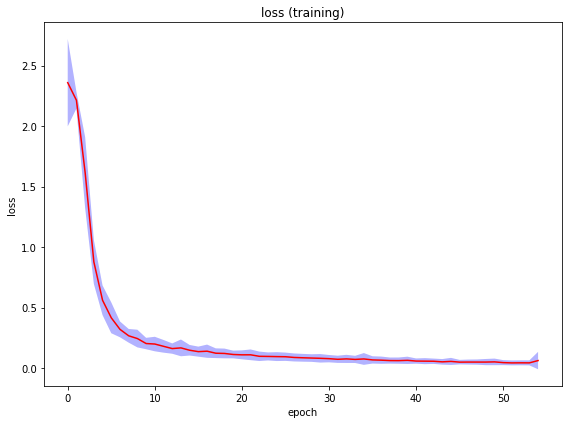


################################################################################
#
# RESULT # 02
#
################################################################################



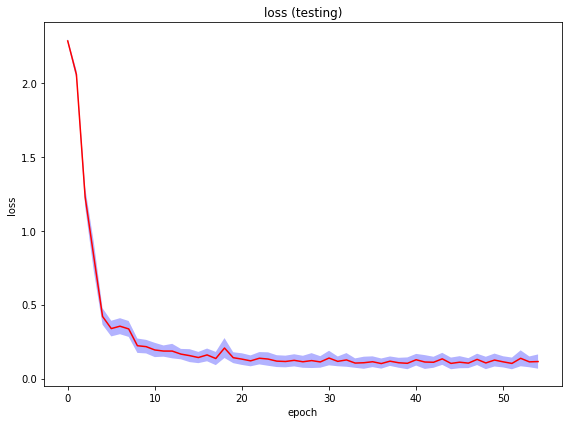


################################################################################
#
# RESULT # 03
#
################################################################################



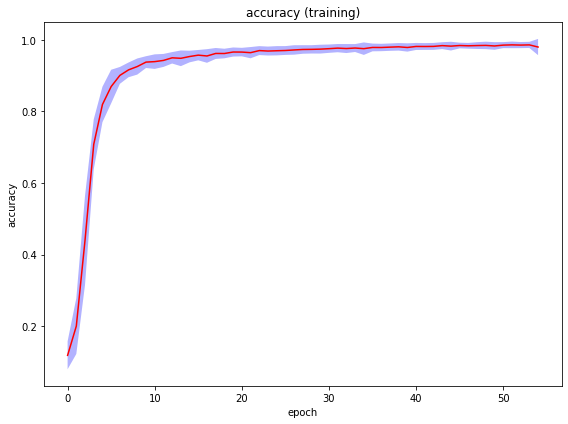


################################################################################
#
# RESULT # 04
#
################################################################################



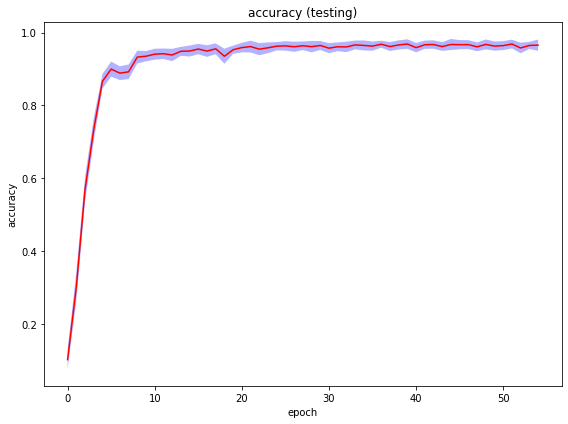


################################################################################
#
# RESULT # 05
#
################################################################################

final training accuracy = 0.98020005

################################################################################
#
# RESULT # 06
#
################################################################################

final testing accuracy = 0.96562499


In [456]:
number_result = 6 

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)